# Is podium


## Dependencies


The dependencies used are as follows


In [1]:
from sklearn.metrics import make_scorer

from xgboost import XGBClassifier, XGBRegressor, XGBRanker

import sys

sys.path.append("..")

from utils.visualization import model_tuning
from utils.custom_cvs import VariableTimeSeriesSplit
from utils.custom_scorers import (
    balanced_accuracy_score,
    balanced_accuracy_ranker,
)

import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings

warnings.simplefilter("ignore")

## Initialization


We continue with the tuning of the model that predicts the podium


In [2]:
df = pd.read_csv("../assets/data/processed/other_models.csv")

mid_rc = df.groupby("raceYear")["raceRound"].max().to_numpy() // 2
get_half = lambda x: f'{x["raceYear"]}{x["raceRound"] <= mid_rc[x["raceYear"] - 2006]}'
instances_per_half = df.apply(get_half, axis=1).value_counts(sort=False).to_numpy()

n_splits = len(instances_per_half) - 10
max_train_size = [instances_per_half[i : 10 + i].sum() for i in range(n_splits)]
test_size = instances_per_half[10:].tolist()
tscv = VariableTimeSeriesSplit(
    n_splits=n_splits, max_train_size=max_train_size, test_size=test_size
)

podiums = df[df["positionFinal"].isin([1, 2, 3])][
    ["raceYear", "raceRound", "driverRef"]
]
podiums = podiums.groupby(by=["raceYear", "raceRound"]).agg({"driverRef": ",".join})

X = pd.read_csv("../assets/data/processed/other_models_X.csv")
y = df.merge(podiums, how="left", on=["raceYear", "raceRound"], suffixes=("", "Podium"))
y = y.apply(lambda x: int(x["driverRef"] in x["driverRefPodium"]), axis=1)

## XGBClassifier


XGBClassifier: 0.796 with {'objective': 'binary:logistic', 'learning_rate':
	0.1881957794020132, 'n_estimators': 191, 'max_depth': 3, 'min_child_weight': 9,
	'gamma': 0.7351767204289907, 'subsample': 0.66252892227608, 'colsample_bytree':
	0.6535285291079885, 'reg_alpha': 3, 'reg_lambda': 56}


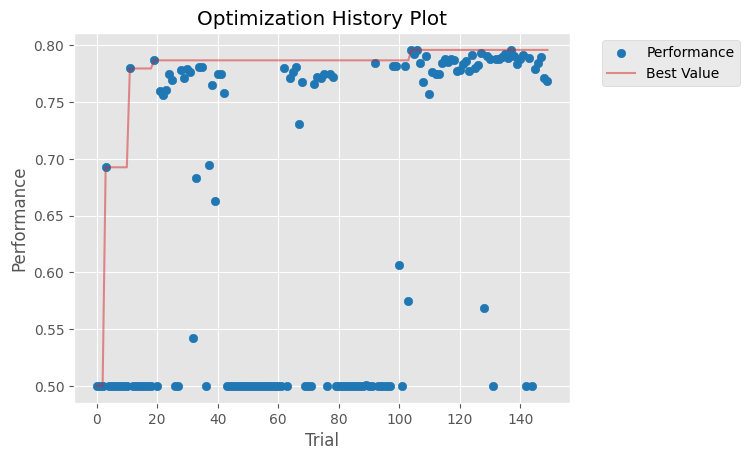

In [3]:
X_selected = X[
    [
        "carNumber",
        "positionGrid",
        "driverNumber",
        "constructorRef",
        "circuitLocation",
        "constructorWins",
        "q3",
        "driverAgeAtRace",
    ]
]
params = [
    ("categorical", ("objective", ["binary:logistic"])),
    ("float", ("learning_rate", 0.01, 0.2)),
    ("int", ("n_estimators", 20, 500)),
    ("int", ("max_depth", 1, 20)),
    ("int", ("min_child_weight", 1, 500)),
    ("float", ("gamma", 0, 0.9)),
    ("float", ("subsample", 0.5, 0.9)),
    ("float", ("colsample_bytree", 0.5, 0.9)),
    ("int", ("reg_alpha", 0, 101)),
    ("int", ("reg_lambda", 0, 101)),
]
model = XGBClassifier
scoring = make_scorer(balanced_accuracy_score)
model_tuning(params, model, X_selected, y, tscv, scoring)

## XGBRegressor


XGBRegressor: 0.826 with {'objective': 'reg:linear', 'learning_rate':
	0.14360979252889314, 'n_estimators': 343, 'max_depth': 7, 'min_child_weight': 229,
	'gamma': 0.3984340120815128, 'subsample': 0.622486602878401, 'colsample_bytree':
	0.7602637443569678, 'reg_alpha': 4, 'reg_lambda': 50}


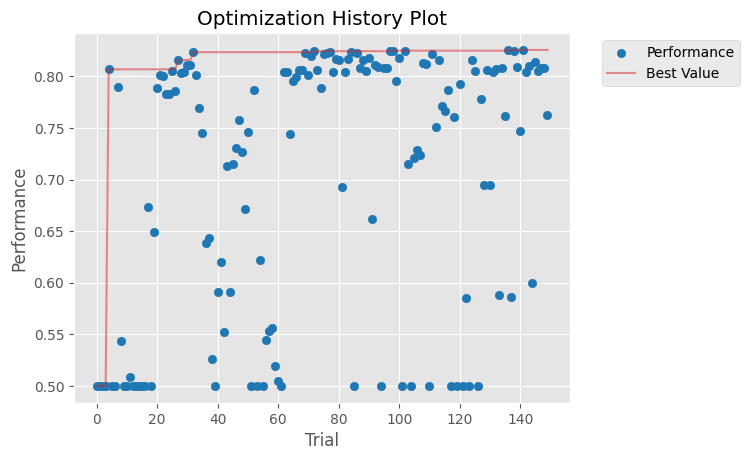

In [4]:
X_selected = X[
    [
        "positionGrid",
        "driverRef",
        "driverNumber",
        "constructorRef",
    ]
]

params = [
    ("categorical", ("objective", ["reg:linear"])),
    ("float", ("learning_rate", 0.01, 0.2)),
    ("int", ("n_estimators", 20, 500)),
    ("int", ("max_depth", 1, 20)),
    ("int", ("min_child_weight", 1, 500)),
    ("float", ("gamma", 0, 0.9)),
    ("float", ("subsample", 0.5, 0.9)),
    ("float", ("colsample_bytree", 0.5, 0.9)),
    ("int", ("reg_alpha", 0, 101)),
    ("int", ("reg_lambda", 0, 101)),
]

model = XGBRegressor

scoring = make_scorer(balanced_accuracy_score)

model_tuning(params, model, X_selected, y, tscv, scoring)

## XGBRanker


XGBRanker: 0.819 with {'objective': 'rank:pairwise', 'learning_rate':
	0.1911219561707857, 'n_estimators': 214, 'max_depth': 14, 'min_child_weight': 89,
	'gamma': 0.2750884232070743, 'subsample': 0.8952242523908255, 'colsample_bytree':
	0.8210155505547994, 'reg_alpha': 13, 'reg_lambda': 27}


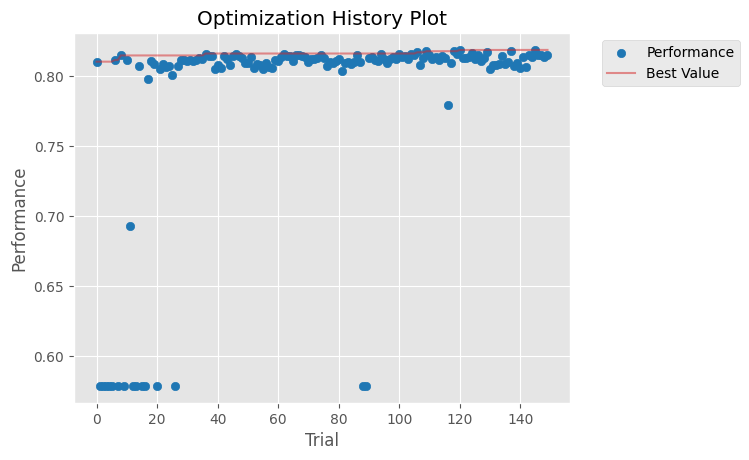

In [5]:
X_selected = X[
    [
        "carNumber",
        "positionGrid",
        "driverRef",
        "driverNationality",
        "constructorRef",
        "constructorNationality",
        "raceYear",
        "raceRound",
        "grandPrix",
        "driverAgeAtRace",
        "qid",
    ]
]
params = [
    ("categorical", ("objective", ["rank:pairwise"])),
    ("float", ("learning_rate", 0.01, 0.2)),
    ("int", ("n_estimators", 20, 500)),
    ("int", ("max_depth", 1, 20)),
    ("int", ("min_child_weight", 1, 500)),
    ("float", ("gamma", 0, 0.9)),
    ("float", ("subsample", 0.5, 0.9)),
    ("float", ("colsample_bytree", 0.5, 0.9)),
    ("int", ("reg_alpha", 0, 101)),
    ("int", ("reg_lambda", 0, 101)),
]
model = XGBRanker
scoring = balanced_accuracy_ranker
model_tuning(params, model, X_selected, y, tscv, scoring)

## Results


Therefore, the tuning for each algorithm are as follows

- XGBClassifier: 0.796 with {'objective': 'binary:logistic', 'learning_rate': 0.1881957794020132, 'n_estimators': 191, 'max_depth': 3, 'min_child_weight': 9, 'gamma': 0.7351767204289907, 'subsample': 0.66252892227608, 'colsample_bytree': 0.6535285291079885, 'reg_alpha': 3, 'reg_lambda': 56}
- XGBRegressor: 0.826 with {'objective': 'reg:linear', 'learning_rate': 0.14360979252889314, 'n_estimators': 343, 'max_depth': 7, 'min_child_weight': 229, 'gamma': 0.3984340120815128, 'subsample': 0.622486602878401, 'colsample_bytree': 0.7602637443569678, 'reg_alpha': 4, 'reg_lambda': 50}
- XGBRanker: 0.819 with {'objective': 'rank:pairwise', 'learning_rate': 0.1911219561707857, 'n_estimators': 214, 'max_depth': 14, 'min_child_weight': 89, 'gamma': 0.2750884232070743, 'subsample': 0.8952242523908255, 'colsample_bytree': 0.8210155505547994, 'reg_alpha': 13, 'reg_lambda': 27}
